# ДЗ Элементарные методы анализа временных рядов


Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель


In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings("ignore") 

In [4]:
robberies_in_boston = pd.read_csv("data/TimeSeries/monthly-boston-armed-robberies-j.csv")


In [10]:
def difference(dataset, lag):
    diff = list()
    for i in range(lag, len(dataset)):
        value = dataset[i] - dataset[i - lag]
        diff.append(value)
    return diff

In [5]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Итоговое представление ряда')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [6]:
def test_stationarity(timeseries):
    print('Results of Jarque-Bera Test:')
    row =  ['JB', 'p-value', 'skew', 'kurtosis']
    jb_test = sm.stats.stattools.jarque_bera(timeseries)
    a = np.vstack([jb_test])
    itog = SimpleTable(a, row)
    print (itog)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
  
    row =  ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    a = np.vstack([dftest])
    itog = SimpleTable(a, row)
    print (itog)
    print ('Critical values: ', dftest[4])
    if dftest[0]> dftest[4]['5%']: 
        print ('\n {:0.2f} >  {:0.2f} есть единичные корни, ряд не стационарен'.format(dftest[0],dftest[4]['5%']))
    else:
        print ('\n {:0.2f} <  {:0.2f} единичных корней нет, ряд стационарен'.format(dftest[0],dftest[4]['5%']))

In [148]:
def series_analyze(series,lag = 12 ):
    series_rezult = np.diff( difference(boxcox(series, 0),lag), 1)  # последовательное разложение ряда
    with plt.style.context('bmh'):
        fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(8,8))

        axs[0].plot(series,     color='blue' )
        axs[0].set_title('Исходный ряд')
       
        axs[1].plot(series_rezult,   color='blue')
        axs[1].set_title('Стационарный ряд')

        fig.show()

    #print(series_rezult)
    
    return series_rezult

## Приводим исходный ряд к стационарному

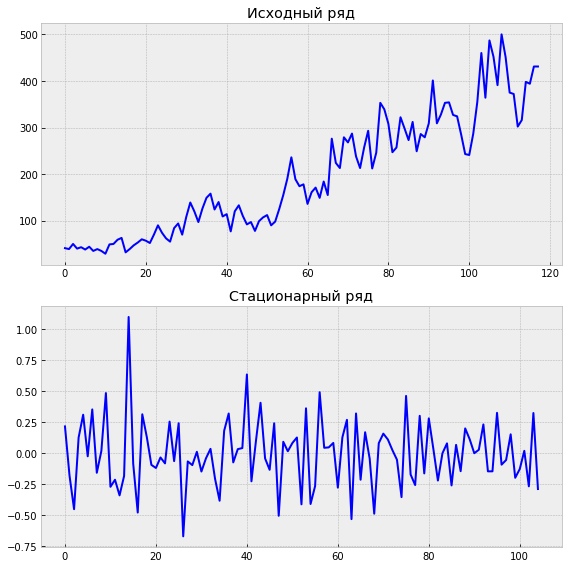

In [149]:
series = robberies_in_boston["Count"]   # исходный нестационарный ряд
series_s = series_analyze(series)    # стационарный ряд

In [30]:
#print(series_s)

# Экспоненциальное сглаживание

In [36]:
# скользящее среднее
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [37]:
# взвешенное скользящее среднее
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [38]:
# экспоненциальное сглаживание
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [39]:
ema = exponential_moving_average(series, 0.2)

In [40]:
len(ema)

118

Лучше всего повторяет ряд взвешенное среднее, так как вес предыдущих значений выше. Это наблюдается и в стационарном ряде.

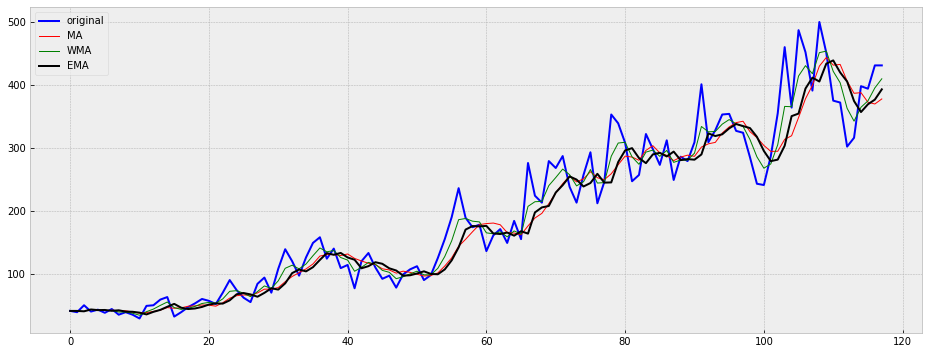

In [127]:
ema = exponential_moving_average(series, 0.3)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

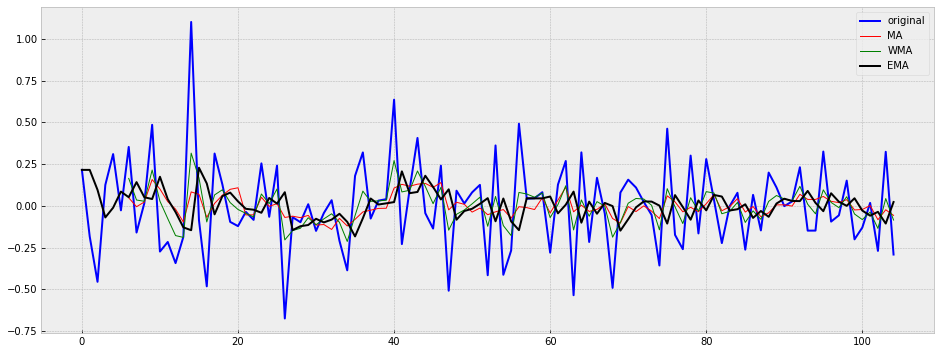

In [128]:
ema = exponential_moving_average(series_s, 0.3)
wma = weighted_moving_average(series_s, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_s, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    plt.plot(series_s, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

Чем меньше 𝛼, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 
Чем меньше 𝛼 тем больше мы опираемся на историю.
При большом значение коэф. сглаживания 𝛼= 0.8 видим сильное смещение и отстаем от тренда, тем меньше мы опираемся на предыдущее значение.

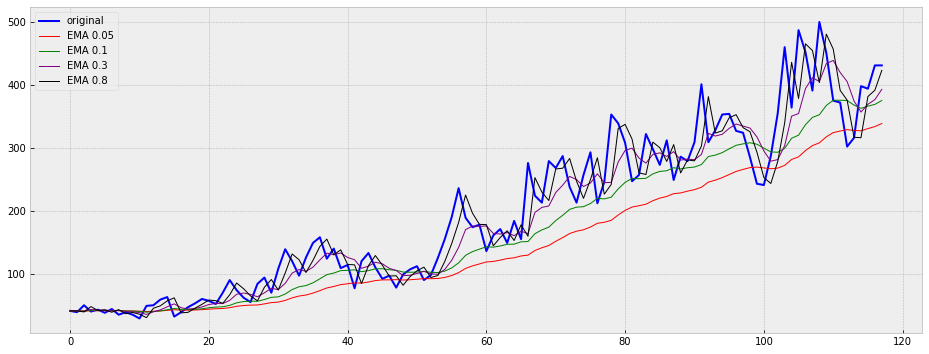

In [126]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

Так как ряд стационарный и тренд уже исключен, высокий коэф. сглаживания убирает только всплески,  смещения не наблюдается

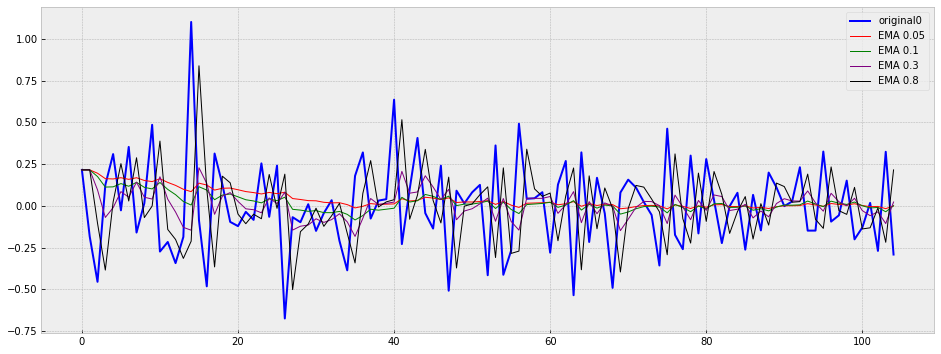

In [129]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    plt.plot(series_s, color='blue',label='original0')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series_s, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

# Двойное экспоненциальное сглаживание

In [61]:
# alpha - коэф влияния уровня, beta - коэф. влияния тренда
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [137]:
def plot_dema(series,alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

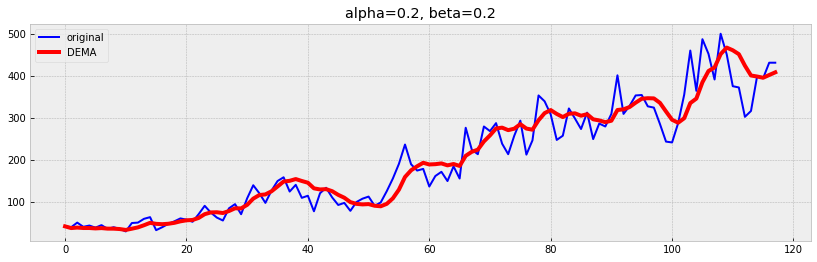

In [138]:
plot_dema(series,0.2, 0.2)

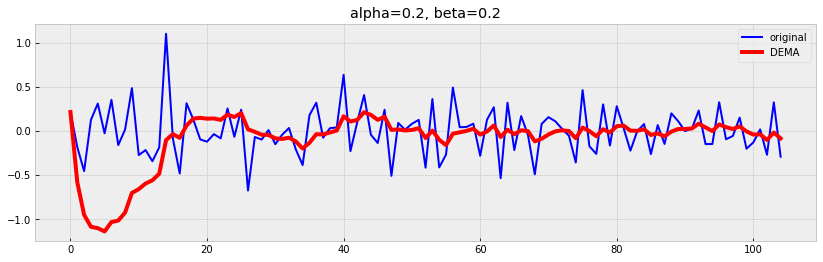

In [139]:
plot_dema(series_s,0.2, 0.2)

Уменьшаем влияние предыдущего несглаженного значения на тренд, влияние на уровень увеличиваем:

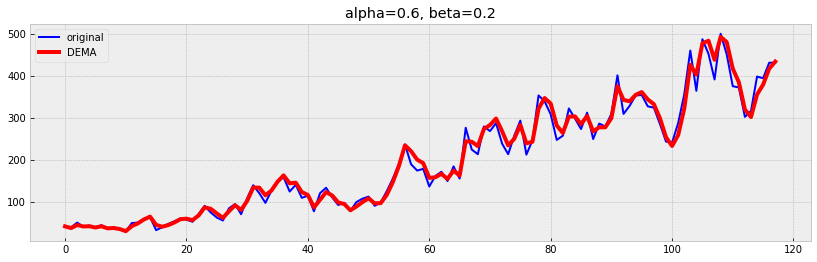

In [140]:
plot_dema(series,0.6, 0.2) 

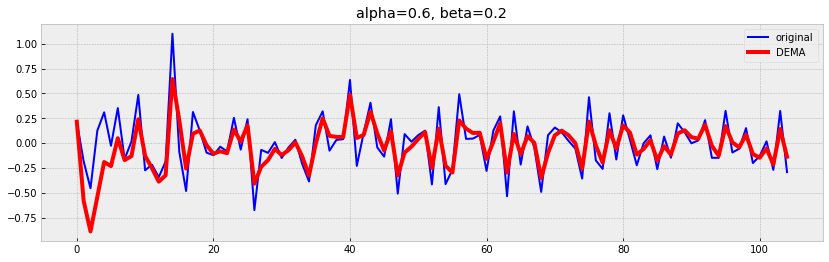

In [141]:
plot_dema(series_s,0.6, 0.2) 

Сильно занижаем влияние предыдущего несглаженного значения на тренд и на уровень, для нестационарного ряда тренд очень запаздывает:

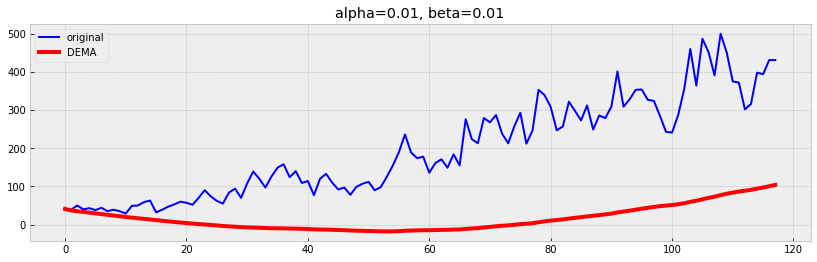

In [144]:
plot_dema(series,0.01, 0.01)  

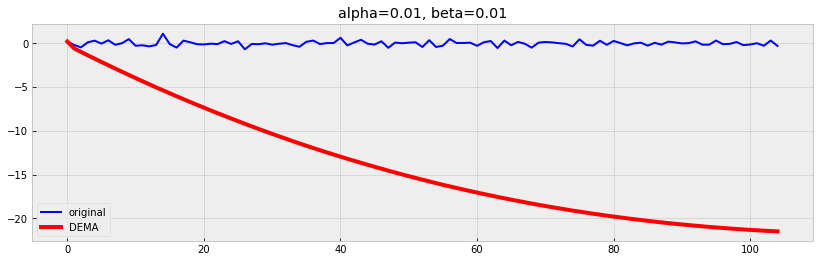

In [150]:
plot_dema(series_s,0.01, 0.01)  

Уменьшаем влияние предыдущего сглаженного значения на тренд и на уровень, сглаженный ряд наоборот еще больше выявляет всплески. Проявляется и на исходном ряде, и на стационарном ряде:

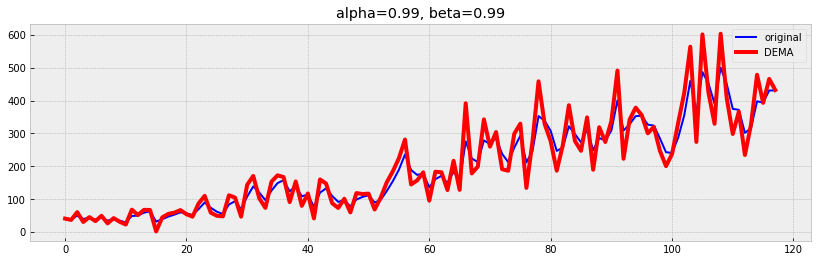

In [146]:
plot_dema(series, 0.99, 0.99)  

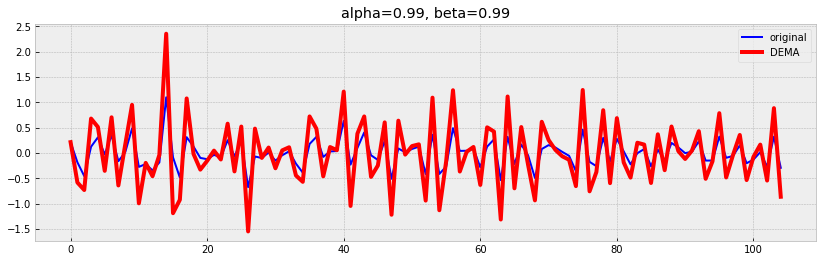

In [147]:
plot_dema(series_s, 0.99, 0.99)   # так как ряд стационарен выявляем уровни, тренд 

### Добавляем сглаживание сезонности

In [70]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [71]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [72]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [162]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(10,4))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

Слабое сглаживание уровней, тренда и более явное выявление сезонности хорошо описывает ряд

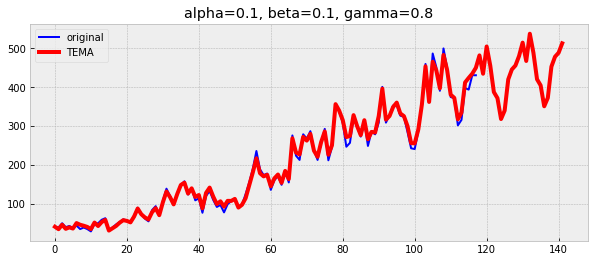

In [179]:
plot_tema(0.1, 0.1, 0.8,series,series)

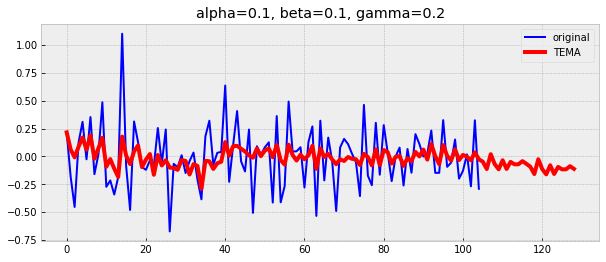

In [165]:
plot_tema(0.1, 0.1, 0.2,series_s,series_s)

Сильное влияние уровней и большое влияние последнего значения, а не всей истории на стационарнм ряде, показывает большое отклонение 

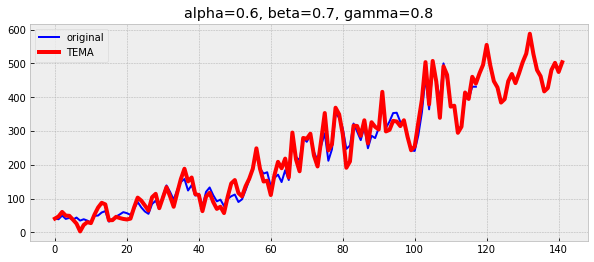

In [166]:
plot_tema(0.6, 0.7, 0.8,series,series)

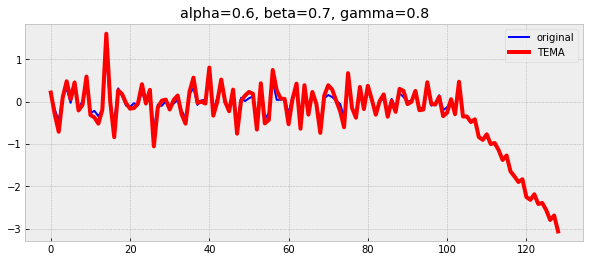

In [167]:
plot_tema(0.6, 0.7, 0.8,series_s,series_s)

Параметры подобраны плохо, нарушен  тренд и неправильно выявлена сезонность

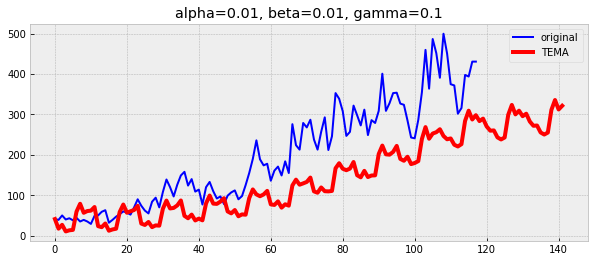

In [175]:
plot_tema(0.01, 0.01, 0.1,series,series)

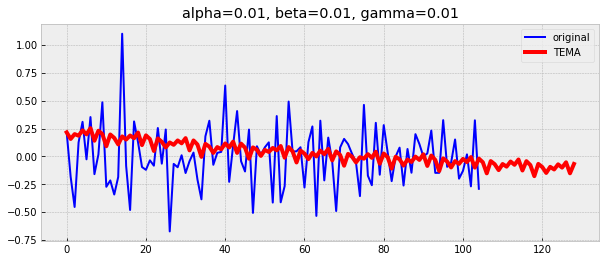

In [177]:
plot_tema(0.01, 0.01, 0.01,series_s,series_s)